## 目标检测和数据集


- bounding box的表示方式
  - $(x_{min}, y_{min}, x_{max}, y_{max})$
  - $(x_{min}, y_{min}, w, h)$
  - $(x_{c}, y_{c}, w, h)$

In [35]:
%matplotlib inline
import torch
import matplotlib.pyplot as plt
from d2l import torch as d2l

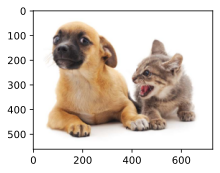

In [36]:
d2l.set_figsize()
img = plt.imread('../img/catdog.jpg')
plt.imshow(img)

In [37]:
def box_corner_to_center(boxes):
    """从(x_min, y_min, x_max, y_max) -> (x_c, y_c, w, h)"""
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    boxes = torch.stack((cx, cy, w, h), dim=-1)
    return boxes

def box_center_to_corner(boxes):
    """从(x_c, y_c, w, h) -> (x_min, y_min, x_max, y_max)"""
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = torch.stack((x1, y1, x2, y2), dim=-1)
    return boxes

In [38]:
x = torch.randn(3, 4)
x1_box = torch.stack((x[:, 0], x[:, 1], x[:, 2], x[:, 3]), dim=-1)
x2_box = torch.stack((x[:, 0], x[:, 1], x[:, 2], x[:, 3]), dim=0)
x, x1_box.shape, x2_box.shape, x1_box, x2_box

(tensor([[-0.4676,  0.3668,  1.4831,  0.0423],
         [ 0.0307, -1.4573,  0.0611,  0.4680],
         [ 0.0484,  2.5398, -0.2220,  0.6574]]),
 torch.Size([3, 4]),
 torch.Size([4, 3]),
 tensor([[-0.4676,  0.3668,  1.4831,  0.0423],
         [ 0.0307, -1.4573,  0.0611,  0.4680],
         [ 0.0484,  2.5398, -0.2220,  0.6574]]),
 tensor([[-0.4676,  0.0307,  0.0484],
         [ 0.3668, -1.4573,  2.5398],
         [ 1.4831,  0.0611, -0.2220],
         [ 0.0423,  0.4680,  0.6574]]))

- 定义猫狗边界框$(x_{min}, y_{min}, x_{max}, y_{max})$

In [39]:
# bbox是边界框的英文缩写
dog_bbox, cat_bbox = [60.0, 45.0, 378.0, 516.0], [400.0, 112.0, 655.0, 493.0]

boxes = torch.tensor([dog_bbox, cat_bbox])
box_center_to_corner(box_corner_to_center(boxes)) == boxes

tensor([[True, True, True, True],
        [True, True, True, True]])

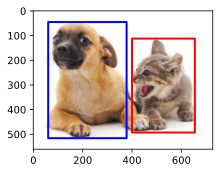

In [40]:
def bbox_to_rect(bbox,color):
    return plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2] - bbox[0], height=bbox[3] - bbox[1],
        fill=False, edgecolor=color, linewidth=2
    )
fig = plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(dog_bbox, 'blue'))
fig.axes.add_patch(bbox_to_rect(cat_bbox, 'red'))

### 数据集

In [41]:
%matplotlib inline
import os
import pandas as pd
import torch
import torchvision
from d2l import torch as d2l

#@save
d2l.DATA_HUB['banana-detection'] = (d2l.DATA_URL + 'banana-detection.zip','5de26c8fce5ccdea9f91267273464dc968d20d72')

In [ ]:
def read_data_bananas(is_train=True):
    """读取香蕉数据集中的图片和标签"""
    data_dir = d2l.download_extract("banana-detection")
    csv_fname = os.path.join(data_dir, 'bananas_train' if is_train else 'bananas_val', 'label.csv')
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    images, targets = [], []
    for img_name, target in csv_data.iterrows():
        images.append(torchvision.io.read_image(
            os.path.join(data_dir, 'bananas_train' if is_train else 
                         'bananas_val', 'images', f'{img_name}')))
        targets.append(list(target))
        # 在中间加一个维度是因为每个图片有很多个标签，表示一张图片中的标签数
    return images, torch.tensor(targets).unsqueeze(1) / 256 # 因为每张图片的大小都是256， 所以在这里做了归一化

images, labels = read_data_bananas(is_train=True)

In [43]:
images = torch.stack(images)
images.shape

torch.Size([1000, 3, 256, 256])

In [44]:
import torch.utils
import torch.utils.data
class BananaDataset(torch.utils.data.Dataset):
    def __init__(self, is_train=True):
        super().__init__()
        self.features, self.labels = read_data_bananas(is_train)
        print("read " + str(len(self.features)) + 
                           (" training examples" if is_train else " validation examples"))
    def __getitem__(self, index):
        return (self.features[index].float(), self.labels[index])
    
    def __len__(self):
        return len(self.features)


- 定义一个函数，获取dataloader

In [45]:
def load_data_bananas(batch_size):
    train_iter = torch.utils.data.DataLoader(BananaDataset(True), batch_size, 
                                             shuffle=True)
    val_iter = torch.utils.data.DataLoader(BananaDataset(False), batch_size)
    return train_iter, val_iter

In [49]:
batch_size, edge_size = 32, 256
train_iter, val_iter = load_data_bananas(batch_size)
batch = next(iter(train_iter))
batch[0].shape, batch[1].shape, batch[1].shape

read 1000 training examples
read 100 validation examples


(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 5]), torch.Size([32, 1, 5]))

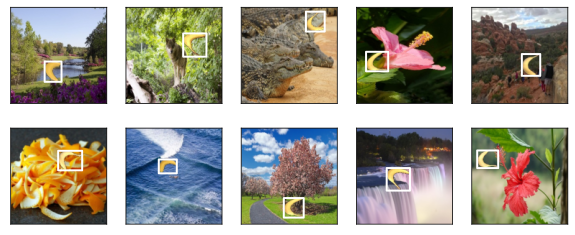

In [50]:
imgs = (batch[0][0:10].permute(0, 2, 3, 1)) / 255
axes = d2l.show_images(imgs, 2, 5, scale=2)
for ax, label in zip(axes, batch[1][0:10]):
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors='w')